In [2]:
#This program demonstrate SLIM image formation and halo removal through projection onto a convex set
%matplotlib inline
import numpy as np 
import numpy.linalg as la
import scipy as sp
import matplotlib.pyplot as plt


In [3]:
print("Demo program for Halo removal")

Demo program for Halo removal


In [4]:
#Imaging parameters
nrows = 1024
ncols = 1024
dimx = 40 #FOV dimensions
dimy = 40
g = 1
dx = dimx/ncols
dy = dimy/nrows
wavelength = 0.532 #microns
beta = 2*np.pi/wavelength
NAo = 0.9;


In [5]:

#Defining functions to generate phase profile
def gen_unif_profile(_nrows,_ncols):
    
    return np.exp(1j*np.zeros((_nrows,_ncols),dtype = np.float32))

def gen_pillars(_nrows,_ncols):
    phase_amp = 2.0;
    [xx,yy]=np.meshgrid(np.linspace(-_ncols/2,_ncols/2-1,_ncols),np.linspace(-_nrows/2,_nrows/2-1,_nrows))
    mask = (np.absolute(xx)<0.2*_ncols)*(np.absolute(yy)<0.2*_nrows)*phase_amp;
    return np.exp(1j*mask)

def gen_beads(_nrows,_ncols):
    return

def err_hdl():
    return "Unknown phase profile"

profile_gen = {"unif": gen_unif_profile(nrows,ncols), "pillars": gen_pillars(nrows,ncols), "beads": gen_beads(nrows,ncols)}#Action dictionary



In [6]:
#Defining condenser aperture pupil
#NAc: numerical aperture of the condenser
def gen_cdn_gaussian(_nrows,_ncols,_dx,_dy,km1): #Gaussian
    [uu,vv]=np.meshgrid(np.linspace(-_ncols/2,_ncols/2-1,_ncols),np.linspace(-_nrows/2,_nrows/2-1,_nrows))
    kx = 2*np.pi*uu/_ncols/_dx
    ky = 2*np.pi*vv/_nrows/_dy
    kp2 = kx*kx + ky*ky
    cdn_tf = np.exp(-0.5*kp2/np.power(km1,2))
    return cdn_tf

def gen_cdn_pupil(_nrows,_ncols,_dx,_dy,km1):
    [uu,vv]=np.meshgrid(np.linspace(-_ncols/2,_ncols/2-1,_ncols),np.linspace(-_nrows/2,_nrows/2-1,_nrows))
    kx = 2*np.pi*uu/_ncols/_dx
    ky = 2*np.pi*vv/_nrows/_dy
    kp2 = kx*kx + ky*ky
    cdn_tf = (kp2<km1*km1)
    return cdn_tf

def gen_cdn_ring(_nrows,_ncols,_dx,_dy,km1,km2):
    [uu,vv]=np.meshgrid(np.linspace(-_ncols/2,_ncols/2-1,_ncols),np.linspace(-_nrows/2,_nrows/2-1,_nrows))
    kx = 2*np.pi*uu/_ncols/_dx
    ky = 2*np.pi*vv/_nrows/_dy
    kp2 = kx*kx + ky*ky
    cdn_tf = (kp2<km2*km2)*(kp2>km1*km1)
    return cdn_tf
cdf_tf_gen = {"gaussian": gen_cdn_gaussian(nrows,ncols,dx,dy,0.2*beta),
              "pupil":gen_cdn_pupil(nrows,ncols,dx,dy,0.09*beta),
              "ring":gen_cdn_ring(nrows,ncols,dx,dy,0.35*beta,0.45*beta)}


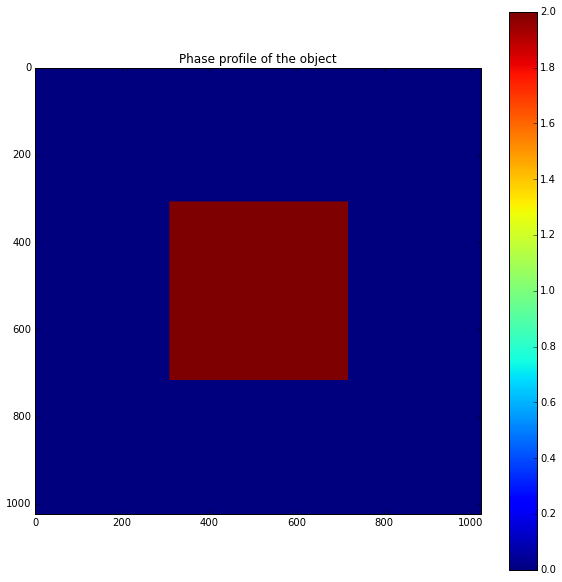

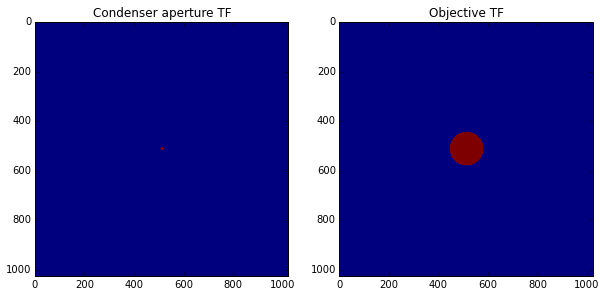

In [7]:
#Generate simulation profile of the object

T = profile_gen.get("pillars",err_hdl)
hif = cdf_tf_gen.get("pupil",err_hdl)
hof = gen_cdn_pupil(nrows,ncols,dx,dy,NAo*beta)
plt.figure(figsize=(10,10))
plt.imshow(np.angle(T)) #Display the output image
plt.colorbar()
plt.title("Phase profile of the object");
plt.figure(figsize=(10,20))
plt.subplot(1,2,1);plt.imshow(hif);plt.title("Condenser aperture TF")
plt.subplot(1,2,2);plt.imshow(hof);plt.title("Objective TF")


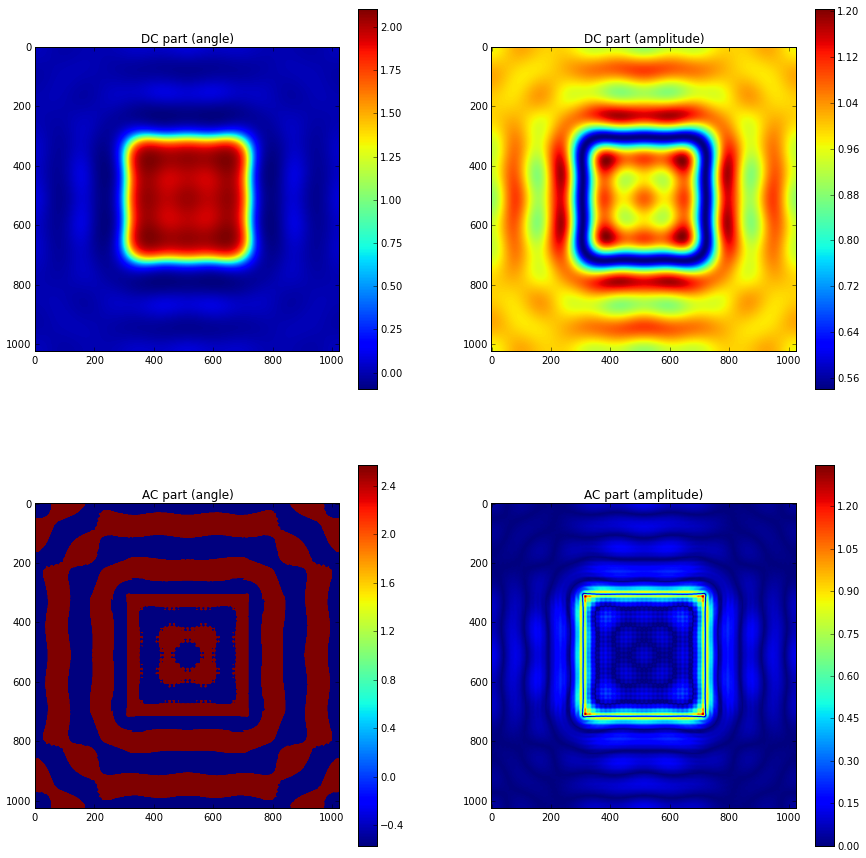

In [8]:
#Generate the AC and DC
Tf = np.fft.fftshift(np.fft.fft2(T))
Uof = Tf*hif*hof #DC part
Usf = Tf*(1-hif)*hof #Ac part
Uo = np.fft.ifft2(np.fft.ifftshift(Uof))
Us = np.fft.ifft2(np.fft.ifftshift(Usf))
plt.figure(figsize=(15,15))
plt.subplot(2,2,1);plt.imshow(np.angle(Uo));plt.title("DC part (angle)");plt.colorbar();
plt.subplot(2,2,2);plt.imshow(np.absolute(Uo));plt.title("DC part (amplitude)");plt.colorbar();
plt.subplot(2,2,3);plt.imshow(np.angle(Us));plt.title("AC part (angle)");plt.colorbar();
plt.subplot(2,2,4);plt.imshow(np.absolute(Us));plt.title("AC part (amplitude)");plt.colorbar();

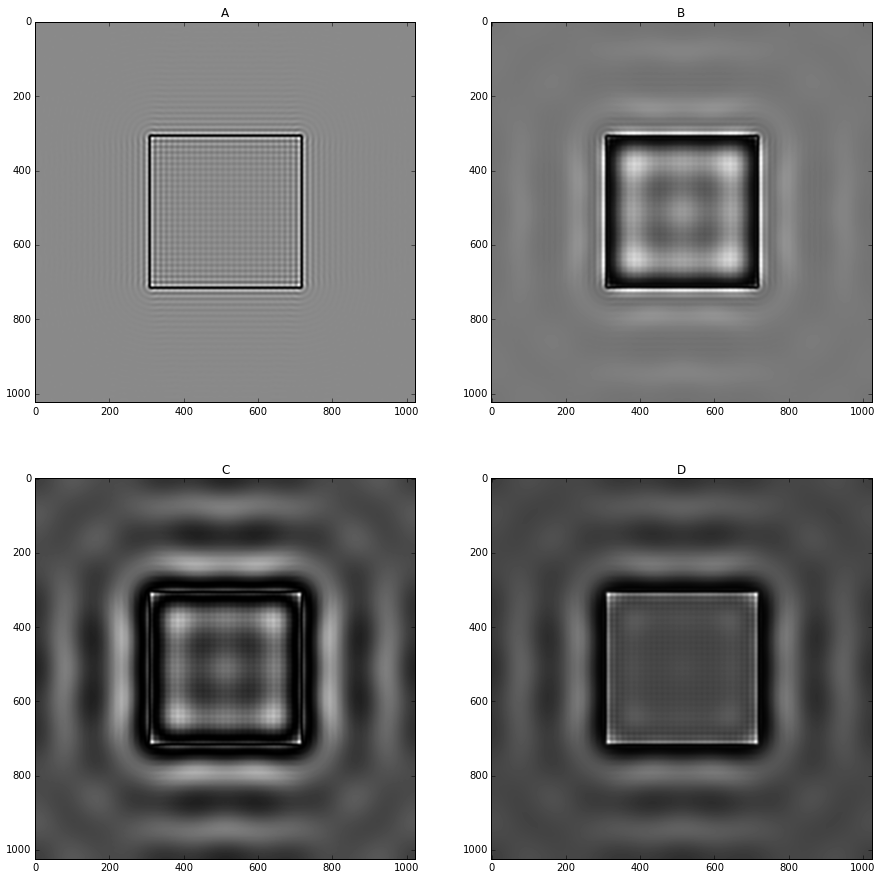

In [9]:
#Generate 4 frames
A = np.power(np.absolute(g*Uo+Us),2);
B = np.power(np.absolute(g*Uo+1j*Us),2);
C = np.power(np.absolute(g*Uo-Us),2);
D = np.power(np.absolute(g*Uo-1j*Us),2);
plt.figure(figsize=(15,15))
plt.subplot(2,2,1);plt.imshow(A,cmap = 'gray');plt.title("A")
plt.subplot(2,2,2);plt.imshow(B,cmap = 'gray');plt.title("B")
plt.subplot(2,2,3);plt.imshow(C,cmap = 'gray');plt.title("C")
plt.subplot(2,2,4);plt.imshow(D,cmap = 'gray');plt.title("D")



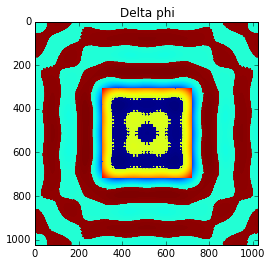

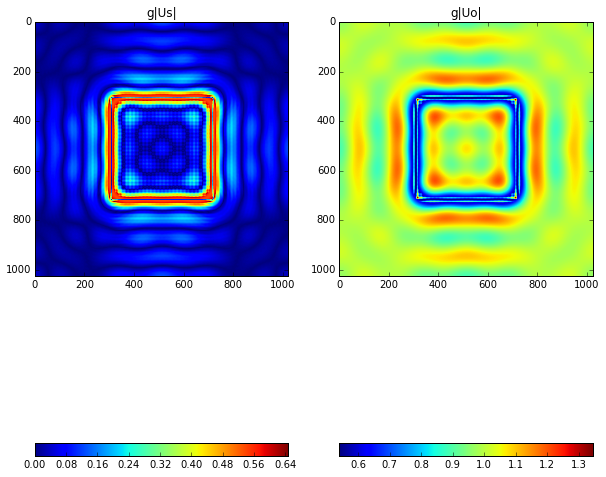

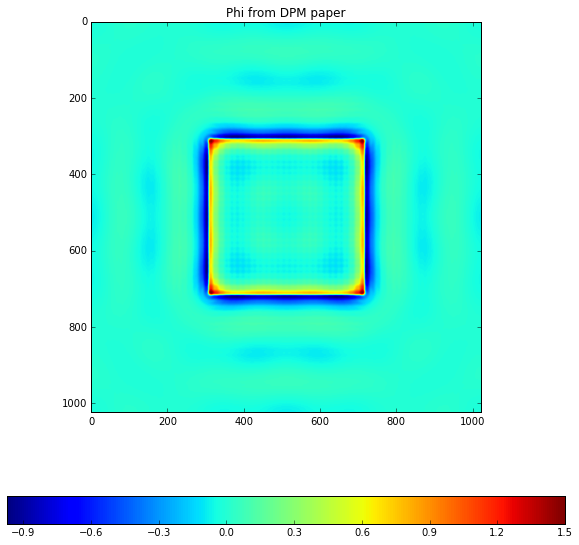

In [10]:
#Compute the two fields, g|Uo| and |Us|
Gs = D-B
Gc = A-C
del_phi = np.arctan2(Gs,Gc);
plt.figure();plt.imshow(del_phi);plt.title("Delta phi")
g1 = (A+C)/2; #|Uo|^2+|Us^2|
L = (A-C+D-B)/(np.sin(del_phi)+np.cos(del_phi))/4;
g2 = L*L;#|Uo|^2*|Us|^2
As = np.sqrt(0.5*(g1-np.sqrt(g1*g1-4*g2)));#AC part
Ao = np.sqrt(0.5*(g1+np.sqrt(g1*g1-4*g2)));#DC part
plt.figure(figsize=(10,20));
plt.subplot(1,2,1);plt.imshow(As,cmap='jet');plt.colorbar(orientation = 'horizontal');plt.title("g|Us|");
plt.subplot(1,2,2);plt.imshow(Ao,cmap='jet');plt.colorbar(orientation = 'horizontal');plt.title("g|Uo|");

#beta=x1/x2/g; #Gives |Uo|/|Us|
#phi=np.arctan2(beta*np.sin(del_phi),1+beta*np.cos(del_phi));
#plt.figure(figsize=(10,10));plt.imshow(phi,cmap='jet');plt.colorbar();plt.title("Phi without background specification")

phi_gamma_ri=np.angle((Uo+Us)*np.conjugate(Uo));
plt.figure(figsize=(10,10));plt.imshow(phi_gamma_ri,cmap='jet');plt.colorbar(orientation = 'horizontal');plt.title("Phi from DPM paper")



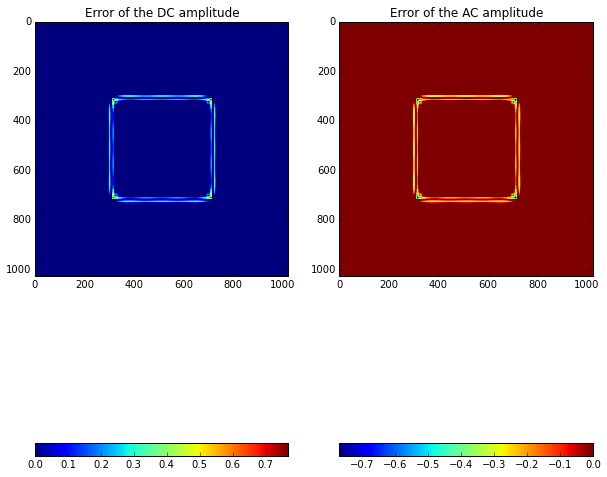

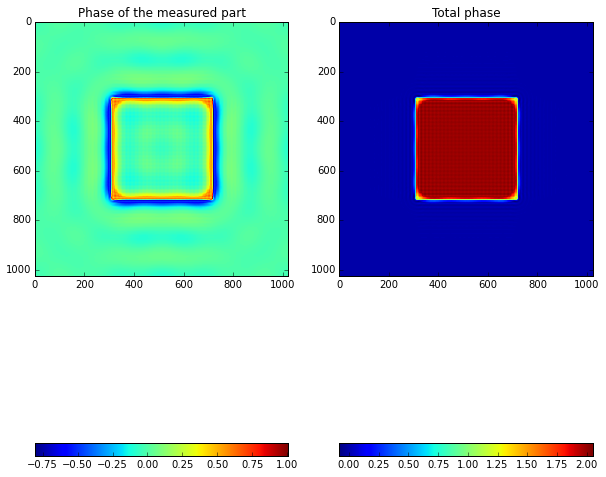

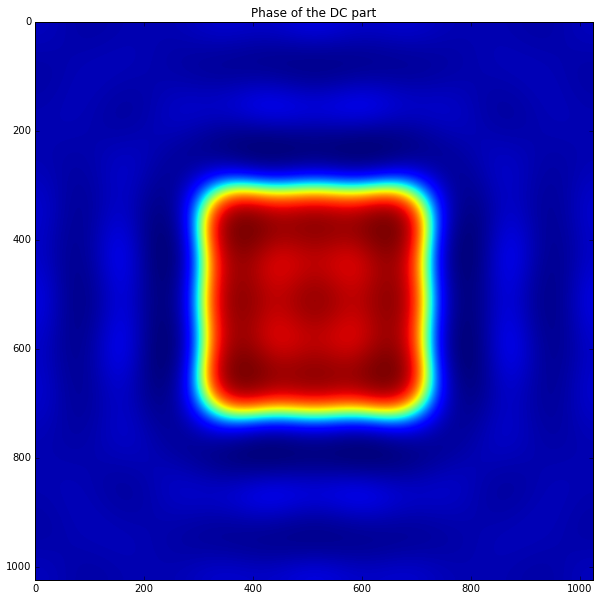

In [11]:
#Inverse solver

plt.figure(figsize=(10,20));
#Double check the result
plt.subplot(1,2,1);plt.imshow(Ao-np.abs(Uo));plt.colorbar(orientation = 'horizontal');plt.title('Error of the DC amplitude');
plt.subplot(1,2,2);plt.imshow(As-np.abs(Us));plt.colorbar(orientation = 'horizontal');plt.title('Error of the AC amplitude');
phi0 = np.angle(Uo)
meas_part = Ao + As*np.exp(1j*del_phi)
Ut_rec = np.exp(1j*phi0)*meas_part
plt.figure(figsize=(10,20))
plt.subplot(1,2,1);plt.imshow(np.angle(meas_part));plt.colorbar(orientation = 'horizontal');plt.title('Phase of the measured part');
plt.subplot(1,2,2);plt.imshow(np.angle(Ut_rec));plt.colorbar(orientation = 'horizontal');plt.title('Total phase');
plt.figure(figsize=(10,10))
plt.imshow(np.angle(Uo));plt.title('Phase of the DC part')


Current error:  (638607.239725-1.4810387432e-15j)
Current error:  (638321.441968+2.83991154093e-15j)
Current error:  (638060.88349-3.73575021662e-15j)
Current error:  (637752.501914-1.38785963448e-15j)
Current error:  (637386.606664-5.41145865516e-16j)
Current error:  (636951.720582+2.34961937876e-15j)
Current error:  (636434.227991+6.86544277652e-16j)
Current error:  (635817.979774+1.09045843771e-15j)
Current error:  (635083.837096+3.38171180712e-15j)
Current error:  (634209.148222-3.89488281186e-15j)
Current error:  (633167.15462-5.69322605104e-16j)
Current error:  (631926.325761+8.64596744826e-16j)
Current error:  (630449.62724+7.20869928874e-15j)
Current error:  (628693.734939+1.43152582355e-14j)
Current error:  (626608.219878+1.14427246933e-14j)
Current error:  (624134.745286-1.88501565917e-15j)
Current error:  (621206.340309+1.16523269116e-14j)
Current error:  (617746.844627+3.65067256807e-15j)
Current error:  (613670.654906+2.34284708544e-15j)
Current error:  (608882.946126+2.98

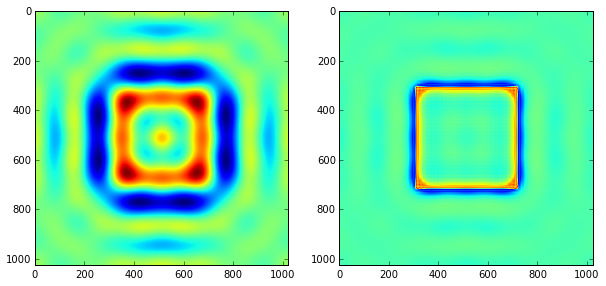

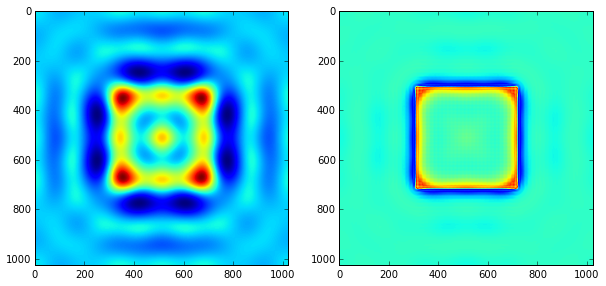

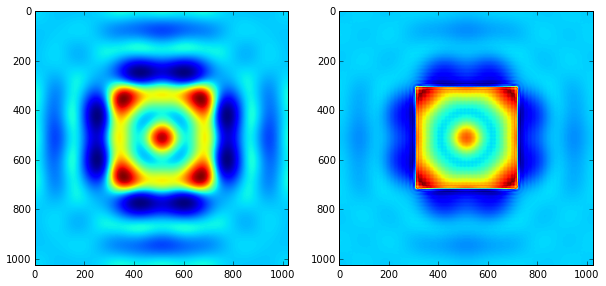

In [15]:
#Start the iterative solver....
niter =50
phik = np.zeros(np.shape(Uo))
Uk = meas_part;
Ukf = np.fft.fftshift(np.fft.fft2(Uk));
Uk_conv_ho = np.fft.ifft2(np.fft.ifftshift(Ukf*hif*hof))#Recompute the low-passed version of the total field
lambdaa = 100;
Tok = np.exp(1j*phik)
Ao = Ao.astype(np.complex128)

def obj_comp(_Uk,_Uk_conv_ho,_Tok,_lambdaa,_measpart,_Ao):
    #Compute the first term
    first_err = _measpart*Tok-_Uk
    second_err = _Ao*_Tok - _Uk_conv_ho
    return np.sum(first_err*np.conjugate(first_err)+_lambdaa*second_err*np.conjugate(second_err))

den = meas_part*np.conjugate(meas_part)+lambdaa*Ao*np.conjugate(Ao)

hf=hif*hof;
hfc = np.conjugate(hf);
den2 = (lambdaa*np.power(np.absolute(hf),2)+1)
meas_partc = np.conjugate(meas_part)
#Compute Tok by solving for the following optimization problem |Uk -Tok*meas_part|^2+lambda*|Ao*Tok-ho*Uk|

for iteridx in np.arange(niter):
    #Solve for Tok given Uk
    num = Uk*meas_partc + lambdaa*Uk_conv_ho*Ao
    Tok = num/den
    phik = np.angle(Tok)
    Tok = np.exp(1j*phik); #Projection onto the unit circle
    
    #Solve for Uk given Tok
    HohAoTokf = hfc*np.fft.fftshift(np.fft.fft2(Ao*Tok))
    rhsf = lambdaa*HohAoTokf + np.fft.fftshift(np.fft.fft2(Tok*meas_part))
    Ukf = rhsf/den2;
    
    Uk = np.fft.ifft2(np.fft.ifftshift(Ukf));
    Uk_conv_ho = np.fft.ifft2(np.fft.ifftshift(Ukf*hf))#Recompute the low-passed version of the total field
    
    print("Current error: ", obj_comp(Uk,Uk_conv_ho,Tok,lambdaa,meas_part,Ao))
       
    if (np.mod(iteridx,20)==0):
        plt.figure(figsize=(10,30))
        plt.subplot(1,2,1);plt.imshow(phik);
        plt.subplot(1,2,2);plt.imshow(np.angle(Uk))
    

    

    
    
    
    

Current error:  (2345.7800481+0j)


In [30]:
A=np.array([[1,2],[3,4]])
B=np.array([[5,6],[7,8]])
print(A/B)

[[ 0.2         0.33333333]
 [ 0.42857143  0.5       ]]
